In [1]:
# review SEG ML contest

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neural_network import MLPRegressor
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
from ukpgks import plots

## Shortly about contest
### Classification problem

features: five logs, two indicators. PE  log missed for some wells

labels   : facies, nine types - multiclass classification

training datasets: nine wells

Approach 1
Convert Well Name and Formation to category type
Hold one well as test data
Have a look at data, plot facies with thier color
Standart scaler features
cross validation train_test_split 0.1 st 42
SVM


In [33]:
# read datasets: train and test
df= pd.read_csv('facies_vectors.csv')
features  = ['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M','RELPOS']
well_logs = ['GR','ILD_log10','DeltaPHI','PHIND','PE']
data = df[df['Well Name']!='Recruit F9'] # psedo well remove
print (data.shape,f"Number of wells {df['Well Name'].unique().size}")

(4069, 11) Number of wells 10


In [34]:
# understanding of targets 
labels_descriptions = pd.read_csv('labels.csv',
                                  header=0,index_col=None,sep=';')
facies_description = dict()
for v,k in zip(labels_descriptions['Description '],labels_descriptions['Facies ']):
    facies_description[k] = v
wellnames = df['Well Name'].unique()
labels_descriptions.head(10)

,Facies,Description,Label,Adjacent Facies
0,1,Nonmarine Sandstone,SS,2
1,2,Nonmarine coarse siltstone,CSiS,1.3
2,3,Nonmarine fine siltstone,FSiS,2
3,4,Marine siltstone and shale,SiSh,5
4,5,Mudstone,MS,4.6
5,6,Wackestone,WS,5.7.8
6,7,Dolomite,D,6.8
7,8,Packstone-grainstone,PS,6.7.9
8,9,Phylloid-algal bafflestone,BS,7.8


In [35]:
# map facies with their colors: 'SS': '#F4D03F'
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
                 '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']


facies_color_map = {} 
facies_label_map = {}

for ind, label in enumerate(facies_names):
    facies_color_map[ind+1] = facies_colors[ind]
    facies_label_map[ind+1] = facies_names[ind]
# create consistent color maping for all facies and abbreviated facies labels
data.loc[:,'FaciesColors'] = data.loc[:,'Facies'].map(facies_color_map)
data.loc[:,'FaciesLabels'] = data.loc[:,'Facies'].map(facies_label_map)
data.loc[:,'FaciesDescrip'] = data.loc[:,'Facies'].map(facies_description)

data.head(3)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesColors,FaciesLabels,FaciesDescrip
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,#DC7633,FSiS,Nonmarine fine siltstone
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,#DC7633,FSiS,Nonmarine fine siltstone
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,#DC7633,FSiS,Nonmarine fine siltstone


In [37]:
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
print (data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4069 entries, 0 to 4148
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Facies         4069 non-null   int64   
 1   Formation      4069 non-null   category
 2   Well Name      4069 non-null   category
 3   Depth          4069 non-null   float64 
 4   GR             4069 non-null   float64 
 5   ILD_log10      4069 non-null   float64 
 6   DeltaPHI       4069 non-null   float64 
 7   PHIND          4069 non-null   float64 
 8   PE             3164 non-null   float64 
 9   NM_M           4069 non-null   int64   
 10  RELPOS         4069 non-null   float64 
 11  FaciesColors   4069 non-null   object  
 12  FaciesLabels   4069 non-null   object  
 13  FaciesDescrip  4069 non-null   object  
dtypes: category(2), float64(7), int64(2), object(3)
memory usage: 422.2+ KB
None


/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_68621/4164799529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Well Name'] = data['Well Name'].astype('category')
/var/folders/xc/cnszhbxs6hn4qsj_h5yt3k7c0000gn/T/ipykernel_68621/4164799529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Formation'] = data['Formation'].astype('category')


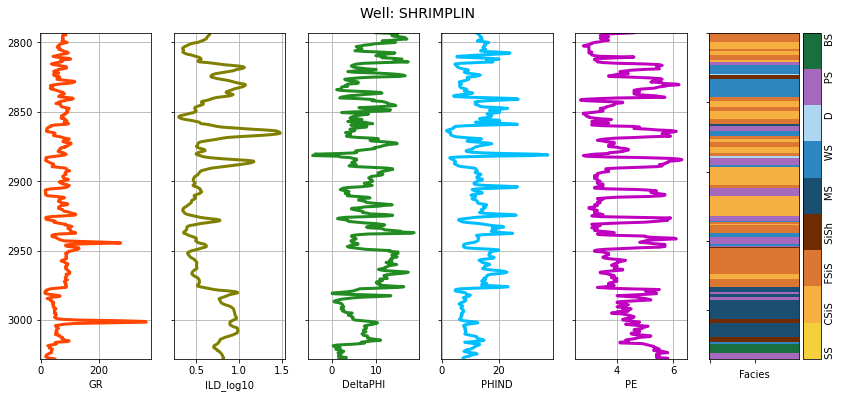

In [39]:
logs = data[data['Well Name'] == 'SHRIMPLIN']
plots.plot_logs(logs,facies_colors)

Nan values in logs:{'PE': 77.75866306217743}


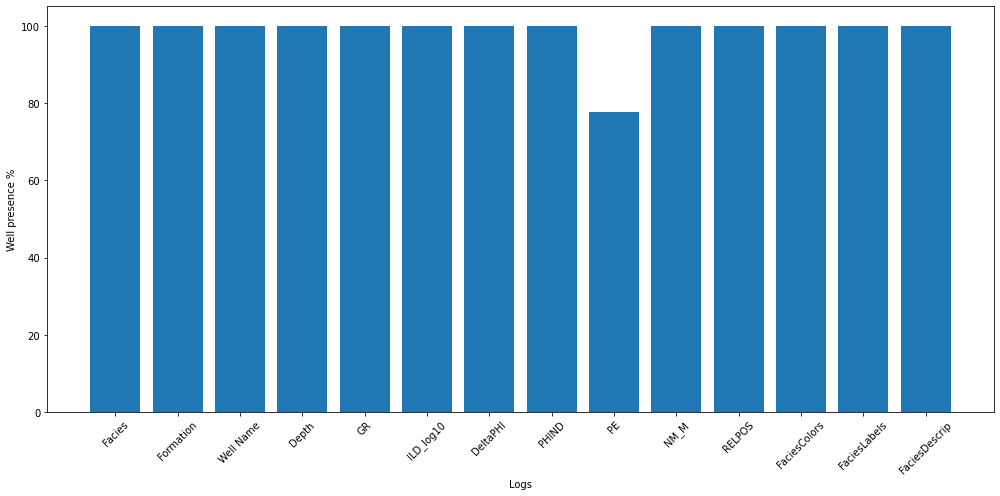

In [45]:
# exploratory data analysis
# find nan values, sum along columns, devide N_obs
train_logs = dict(100-data.isna().sum() /
                 data.shape[0] * 100)
logs_w_nan = {log:value for log,value in train_logs.items() if value!=100}
print (f'Nan values in logs:{logs_w_nan}')
# occurences of logs in wells
plt.figure(figsize=(14,7))
plt.bar(train_logs.keys(),train_logs.values())
plt.xticks(list(train_logs.keys()),rotation=45)
plt.xlabel('Logs');plt.ylabel('Well presence %');plt.tight_layout()

Text(0.5, 0, 'Facies')

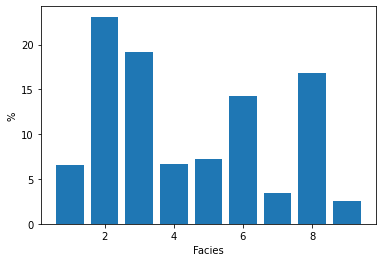

In [61]:
l = data.Facies.value_counts()
l =  (dict(sorted(l.items())))
l_perc  = np.array(list(l.values()))/data.shape[0] * 100
l_names = l.keys()
# fig = plt.figure(figsize=(15,10))
plt.bar(l_names,l_perc); plt.ylabel('%');plt.xlabel('Facies')

{1: 'SS',
 2: 'CSiS',
 3: 'FSiS',
 4: 'SiSh',
 5: 'MS',
 6: 'WS',
 7: 'D',
 8: 'PS',
 9: 'BS'}

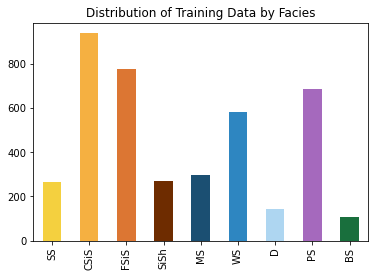

In [71]:
facies_counts = data['Facies'].value_counts().sort_index()
facies_counts.index = facies_label_map.values()
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')

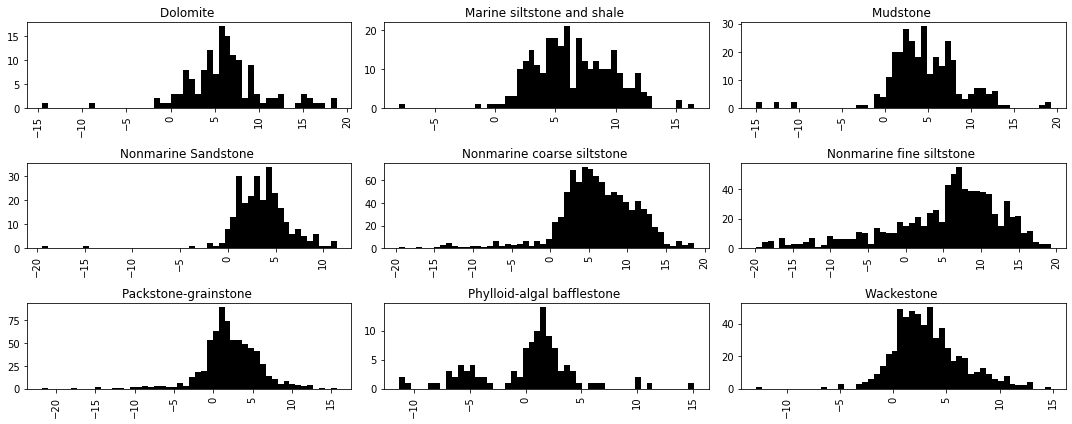

In [12]:
# plot hist for logs
# facies shpuld have diff properties to classify them or separate from each other
datasets.DeltaPHI.hist(bins=50,by=datasets['FaciesDescrip'],color='k',
                          figsize=(15,6), layout=(3,3),lw=0)
plt.tight_layout()



#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)



In [13]:
# data imputation 
# replace by regression predictions
logs = ['GR','ILD_log10','DeltaPHI','PHIND']
print ('Missing values of PE log in wells',
       datasets[datasets['PE'].isna()]['Well Name'].unique())

pe_train_data = datasets.loc[~datasets['Well Name'].isin(\
                ['ALEXANDER D','KIMZEY A']),:]

pe_test_data = datasets.loc[datasets['Well Name'].isin(\
                ['KIMZEY A','ALEXANDER D']),:]
                                                             
print (datasets.shape,pe_train_data.shape)
print (datasets.shape[0]-pe_train_data.shape[0],pe_test_data.shape)

Missing values of PE log in wells ['ALEXANDER D' 'KIMZEY A']
(4069, 14) (3164, 14)
905 (905, 14)


In [14]:
lr = MLPRegressor(activation='relu',
                 hidden_layer_sizes=(100, 40), random_state=1)


X_train = pe_train_data.loc[:,logs]
y_train = pe_train_data.loc[:,'PE']
X_test  = pe_test_data.loc[:,logs]

    
print (X_train.shape,y_train.shape,X_test.shape)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print(lr.score(X_train,y_train))


(3164, 4) (3164,) (905, 4)
0.5660348586842121


In [15]:
datasets.loc[datasets['Well Name'].isin(\
                ['KIMZEY A','ALEXANDER D']),'PE'] = y_pred

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


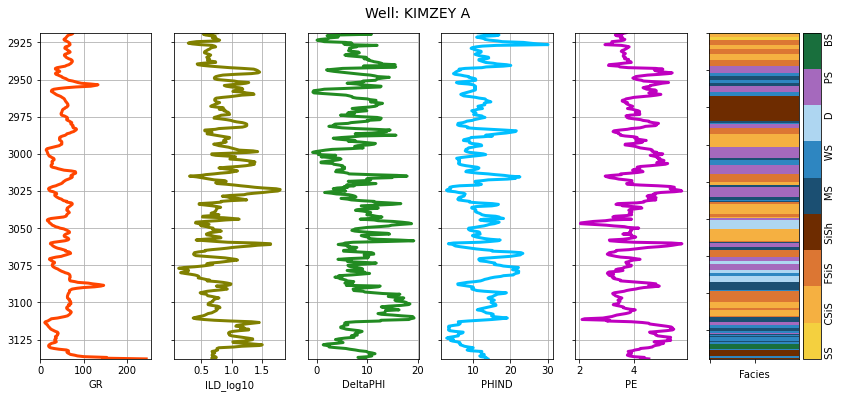

In [17]:
logs = datasets[datasets['Well Name'] == 'KIMZEY A']
plots.plot_logs(logs,facies_colors)

In [18]:
datasets.loc[:,'Facies'] = datasets.loc[:,'Facies'].astype('category')
train = datasets.loc[datasets['Well Name']!='SHANKLE',:]
test = datasets.loc[datasets['Well Name']=='SHANKLE',:]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [19]:
xgb = XGBClassifier(max_depth=7,
                   learning_rate=0.1,
                   n_estimators=500,
                   )

In [20]:
xgb.fit(train.loc[:,features],train.loc[:,'Facies'])

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:15:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1634712680264/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [21]:
y_pred = xgb.predict(test.loc[:,features])

In [22]:
conf = confusion_matrix(test.loc[:,'Facies'],y_pred)
conf

array([[ 7, 81,  1,  0,  0,  0,  0,  0],
       [ 7, 66, 16,  0,  0,  0,  0,  0],
       [ 1, 53, 63,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  2,  0,  0,  3],
       [ 0,  0,  0,  9,  1,  0,  1,  8],
       [ 0,  0,  2,  6, 10, 39,  1, 13],
       [ 0,  0,  0,  0,  0,  1, 13,  3],
       [ 0,  0,  0,  0,  0, 16,  2, 22]])

In [23]:
xgb.score(test.loc[:,features],test.loc[:,'Facies'])

0.47438752783964366

In [24]:
accuracy_score(test.loc[:,'Facies'],y_pred)

0.47438752783964366

In [25]:
f1_score(test.loc[:,'Facies'],y_pred,average='macro')

0.41586955230542233

In [27]:
def cart2pol(df,features):
    """
    convert cartesian coordinates to polar coordinates
    """
    df_polar = df.copy()
    fea_red = features[:]
    for feature1 in features:
        fea_red = fea_red[1:]
        for feature2 in fea_red:
            x = df.loc[:,feature1].values - df.loc[:,feature1].mean()
            y = df.loc[:,feature2].values - df.loc[:,feature2].mean()
            df_polar.loc[:,feature1+'_'+feature2+'_rho'] = np.sqrt(x**2 + y**2)
            df_polar.loc[:,feature1+'_'+feature2+'_phi'] = np.arctan2(y,x)
    
    return df_polar
    

In [32]:
datasets_polar['Facies'].unique()

[3, 2, 8, 6, 7, 4, 5, 9, 1]
Categories (9, int64): [1, 2, 3, 4, ..., 6, 7, 8, 9]

In [28]:
datasets_polar = cart2pol(datasets,well_logs)

In [29]:
datasets_polar.iloc[:,:]

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,...,ILD_log10_PHIND_rho,ILD_log10_PHIND_phi,ILD_log10_PE_rho,ILD_log10_PE_phi,DeltaPHI_PHIND_rho,DeltaPHI_PHIND_phi,DeltaPHI_PE_rho,DeltaPHI_PE_phi,PHIND_PE_rho,PHIND_PE_phi
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,...,1.295919,-1.568268,0.854131,1.566961,5.606167,-0.233269,5.520801,0.155334,1.552071,2.558854
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,...,0.645915,-1.570369,0.354125,1.570017,9.775692,-0.066122,9.760756,0.036288,0.736621,2.640091
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,...,0.160938,-1.587723,0.145900,-1.589468,10.355580,-0.015540,10.355358,-0.014087,0.217194,-2.405179
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,...,0.096086,-1.630404,0.245942,-1.594073,9.454817,-0.010145,9.457527,-0.026001,0.263921,-1.942736
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,...,0.090136,1.723651,0.346147,-1.610455,9.054768,0.009839,9.060934,-0.038181,0.357163,-1.318711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,...,5.963790,-1.522776,0.313947,-0.423001,6.506691,-1.984829,2.620840,-3.092400,5.958309,-3.119962
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,...,5.206126,-1.514626,0.496919,-0.941995,5.646139,-1.971943,2.240998,-2.961289,5.213427,-3.064432
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,...,5.206755,-1.512517,0.633224,-1.071351,5.415788,-1.855408,1.619084,-2.791136,5.227554,-3.035056
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,...,5.511321,-1.515559,0.667286,-1.097312,5.669122,-1.813540,1.486458,-2.730596,5.534868,-3.034089


In [14]:
c = well_logs[:]

In [15]:
c

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']

In [16]:
well_logs[1] = 'Umed'

In [17]:
well_logs

['GR', 'Umed', 'DeltaPHI', 'PHIND', 'PE']

In [18]:
c

['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']

In [21]:
c = well_logs[:]
for feature1 in well_logs:
    c =c[:-1]
    print (c)

['GR', 'Umed', 'DeltaPHI', 'PHIND']
['GR', 'Umed', 'DeltaPHI']
['GR', 'Umed']
['GR']
[]


In [22]:
well_logs

['GR', 'Umed', 'DeltaPHI', 'PHIND', 'PE']

In [28]:
x = datasets.loc[:,'PE'].values - datasets.loc[:,'PE'].mean()

In [29]:
dff = datasets.copy()

In [31]:
dff.loc[:,'gr'+'pe'] = x

In [36]:
np.arctan2(100,22)

1.3542460218188073